In [1]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [2]:
HTML('''
<script>
    function toggleCodeCells() {
      var codeCells = document.querySelectorAll('.jp-CodeCell');

      codeCells.forEach(function(cell) {
        var inputArea = cell.querySelector('.jp-InputArea');
        if (inputArea) {
          var currentDisplay = inputArea.style.display || getComputedStyle(inputArea).display;
          inputArea.style.display = currentDisplay === 'none' ? '' : 'none';
        }
      });
    }
</script>

<!-- Add a button to toggle visibility of input code cells -->
<button onclick="toggleCodeCells()">Toggle Code Cells</button>
''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10791: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.renebreton.org">Prof. Rene Breton</a> - Twitter <a href="https://twitter.com/BretonRene">@BretonRene</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Dr. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

## Syllabus

1. Probabilities and interpretations
2. Probability distributions
3. Parameter estimation
4. Maximum likelihood
5. **Least square, chi2, correlations**
6. Monte Carlo basics
7. Goodness of fit tests
8. Hypothesis testing
9. Probability and confidence level
10. Limit setting
11. Introduction to multivariate analysis techniques

# Chapter 5

## Topics

**[5.1 Bayesian inference - Part 2](#5.1-Bayesian-inference---Part-2)**
- 5.1.1 Combining results
- 5.1.2 On the use of priors

**[5.2 Least square](5.2-Least-square)**
- 5.2.1 Least square derivation
- 5.2.2 Linear least squares
- 5.2.3 Chi-square distribution
- 5.2.4 Non-linear least squares
- 5.2.5 Best linear unbiased estimator
- 5.2.6 Other topics

## Further Reading Material

- **Cowan**: Chapter 6.12 and 6.13 - *Combining results and priors*
- **Cowan**: Chapter 7 (sections 7.1, 7.2 and 7.3) - *Least squares method*
- **Barlow**: Chapter 6 - *Least squares method*

<img src="images/frequentists_vs_bayesians_2x.png" width="40%">

_[Source: XKCD](https://www.xkcd.com/1132/)_

[Read the explanation on Explain XKCD](https://www.explainxkcd.com/wiki/index.php/1132:_Frequentists_vs._Bayesians)

This carton relates to the [base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy).

Need more information about Bayes inference? How about reading [A Narwhal's Guide to Bayes' Rule](https://www.embedded.fm/blog/2016/9/1/a-narwhals-guide-to-bayes-rule)? This is a funny way to learn Bayes' rule.

## 5.1 Bayesian inference - Part 2

With Bayesian statistics we have a framework to evaluate the posterior probability of an event/parameter/hypothesis. We also have seen that the maximum a posteriori and its simpler version the maximum likelihood, which applies for flat priors, are generally good estimators. These estimators are useful means of summarising the parameter(s) of interest using a central quantity (i.e. the MAP/MLE) and their spread (i.e. variance on the parameters using, e.g., the covariance matrix) rather than describing the entire posterior probability distribution.

### 5.1.1 Combining results

The next logical step in our understanding of (Bayesian) inference is to determine how should results from independent experiments be combined together. The procedure was in fact laid out at the start of the semester: 'the joint probability of two independent events is equal to the product of their probabilities'.

This means that if you obtain a posterior probability $P(a \mid D_1)$ from a first experiment and $P(a \mid D_2)$ from a second experiment, their joint probability (i.e. their intersection) will be:
\begin{equation}
  P(a \mid D_1 \cap D_2) = P(a \mid D_1) \, P(a \mid D_2) \,.
\end{equation}

The same would equally apply to the likelihoods in the case where priors are flat. Note that in the log-probability space, this would correspond to summing the log-probabilities rather than multiplying them. Also, one should generally ensure that the product is renormalised to unity.

Two ways of calculating the joint probabilities:

1. The product of the two distributions can be calculated directly if we know their analytical representation. This would be the case, for example, if the two posterior distributions are Gaussians. Indeed, the product of two Gaussians is also a Gaussian. _[Try calculating it yourself as it is a very useful and common result.]_
2. Generally speaking, obtaining the joint probability of two measurements requires one to have a full description of their individual probability so that their product can be computed numerically (see the example below).

<div class="example">Example 1: Combining the posterior probabilities 'analytically'</div>

One of the 'holy grails' of cosmology is to detect the so-called B-mode polarisation in the cosmic microwave background. It turns out that their amplitude is related to the production of gravitational waves during the early Universe inflation in what is called the tensor-to-scalar ratio, $r$.

<img src="images/CMB_polarisation.png" width="60%">

_[Source: [WMAP](https://map.gsfc.nasa.gov)]_

Several experiments have attempted to measure this effect without success. Nevertheless these non-detections can prove to be important for our understanding of physics, especially if it is theoretically possible for the value of $r$ to be zero.

Imagine that a first experiment obtains a constraint on $r$ which follows a decreasing exponential: $P(r \mid \tau_1) = \frac{1}{\tau_1} e^{-\frac{r}{\tau_1}}$. From this we could evaluate an upper limit on $r$ corresponding to a certain confidence level (we will investigate this topic in future lectures).

Imagine that a second, independent experiement obtains a constraint on $r$ which also follows a decreasing exponential: $P(r \mid \tau_2) = \frac{1}{\tau_2} e^{-\frac{r}{\tau_2}}$.

What would be the joint constraint based on the two experiments? We can multiply the probabilities, and renormalise:
\begin{eqnarray}
  P(r \mid \tau_1, \tau_2) &=& P(r \mid \tau_1) \, P(r \mid \tau_2) \\
    &=& \left(\frac{1}{\tau_1} + \frac{1}{\tau_2}\right) \exp \left[-\left(\frac{1}{\tau_1} + \frac{1}{\tau_2}\right) r\right] \,.
\end{eqnarray}

It is therefore clear that combining different experiments could improve the limits on $r$.

_Note, however, that real-life situation is more complicated: distribution might not be exponential and systematic uncertainties might prevent upper limits from improving beyond a certain point._

<div class="example">Example 2: Combining the posterior probabilities 'numerically'</div>

Below is the archetypical illustration of joint probability. This illustrates the joint constrainst from various cosmological experiments for the so-called lambda cold dark matter (aka lambda-CDM) model parameters. The joint constraint is showed near the centre. Clearly, this can only be calculated numerically using a point-to-point multiplication.

<img src="images/cosmo_summary_allen11.png" width="50%">

_[Source: Allen et al., 'Measuring cosmic distances with galaxy clusters', [arXiv:1307.8152](https://arxiv.org/abs/1307.8152)]_

### 5.1.2 On the use of priors

The prior probability, often simply called prior, is a fundamental component of Bayesian statistics. It represents one's degree of belief into the quantity/parameter that is to be estimated before some evidence is taken into account. Priors are typically used to constrain parameters, either from past information (e.g. deduced from another experiment) or in order to keep parameter values in line with expectations (e.g. keeping the parameter within a physical range).

_Note: in general the prior probability is normalised so that its integral is unity._

**Combining results (as we have seen in the previous subsection) by multiplying probabilities and using priors are completely interchangeable in the mathematical sense.**

This is due to priors and posteriors being independent of the data. This means that, for instance, you could conduct two experiments independently and combine their results afterwards or, alternatively, you could use the results of one experiment and use it as a prior for the second experiment.

On the practical side, there are many advantages to using priors rather than multiplying posterior probabilities. Imagine for instance that you cannot evaluate the MLE analytically like it was the case for the _'maximum likelihood of a simple function'_ example from last week. Finding the MLE, $\widehat{a}$, required to numerically identify the maximum of the likelihood function. If, for some reason, we knew that $a \in [-0.7, -0.5]$, this would considerably reduce the values of $a$ to search for.

Optimization terminated successfully.
         Current function value: -0.068503
         Iterations: 10
         Function evaluations: 20
ln_L_max: 0.068503
a_max: -0.59162


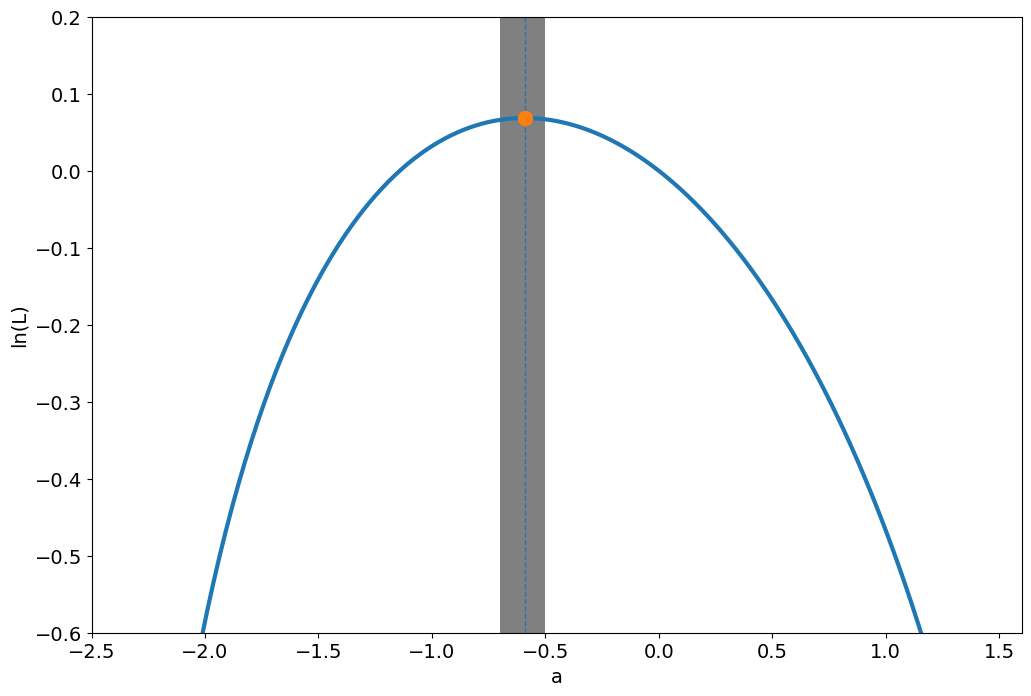

In [3]:
## The data
x = np.r_[0.89, 0.03, 0.50, 0.36, 0.49]

## The model
P = lambda a_: 1 + a_*(x - 0.5)
ln_L = lambda a_: np.log(P(a_)).sum()

## Finding the maximum likelihood
a_max = scipy.optimize.fmin(lambda a_: -ln_L(a_), -0.6)[0]
ln_L_max = ln_L(a_max)
print('ln_L_max: {:.5}'.format(ln_L_max))
print('a_max: {:.5}'.format(a_max))

## Evaluating the model at a 
a = np.linspace(-2.1,1.2,241)
calc_ln_L = []
for ai in a:
    calc_ln_L.append( ln_L(ai) )

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_betweenx([-0.6,0.2], -0.7, -0.5, facecolor='gray')
ax.plot(a, calc_ln_L, lw=3)
ax.vlines(a_max, -0.6, 0.2, linestyles='--', lw=1)
ax.plot([a_max], [ln_L_max], 'o', ms=10)
ax.set_xlabel('a')
ax.set_ylabel('ln(L)')
ax.set_xlim(-2.5,1.6)
ax.set_ylim(-0.6,0.2);

Another practical situation would be if you are fitting a straight line, $y = mx + b$, and know that the value of $b$ is strictly larger or equal to zero. Priors give you an easy way of dealing with this situation as you can set a function:
\begin{equation}
  P(b) = 
    \begin{cases}
    1 & {\rm if}\,b \ge 0 \\
    0 & {\rm if}\,b < 0 \,.
    \end{cases}
\end{equation}

#### Flat priors

Flat priors are constant and independent of the parameters (i.e. $I(a) = C$). The normalisation requirement is such that:

\begin{equation}
  \int_{a_{\rm min}}^{a_{\rm max}} C\, {\rm d}a = 1 \,,
\end{equation}

which implies that $I(a) = \frac{1}{a_{\rm max}-a_{\rm min}}$. The generalisation of this to the case where $a$ is multi-dimensional is $P(a) = \frac{1}{V_a}$, where $V_a$ is the hyper volume of parameter space occupied by $a$. For MAP, this is irrelevant as this constant disappears when the derivative with respect to $a$ is taken. However, it has a significance for advanced Bayesian inference (e.g. for model comparison).

#### Improper priors

There situations where the priors cannot be normalised to a finite value. This is the case for flat priors with unconstrained range (e.g. $(-\infty,+\infty)$ or $[0,+\infty)$). We call them _improper priors_.

Once again, because of the independence of the prior with respect to the parameter to optimise, it does not matter to calculate the MAP. Furthermore, the posterior probability can still be normalised as long as the likelihood itself can be normalised. An example would be if the improper prior is a constant line. If the likelihood is a Gaussian, then their product is a Gaussian and can be normalised.

<img src="images/bayesevol.png" width="60%">

<div class="example">Example 1: MAP of a simple lifetime</div>

Let us recall the radioactive decay example from the previous chapter with the likelihood given by

\begin{equation}
  \mathcal{L}(t_i \mid \tau) = \frac{1}{\tau} e^{-t_i/\tau} \,.
\end{equation}

What if there is a non-constant prior $I \propto \tau^{-1}$? We can no longer use MLE and need to use MAP instead. Hence

\begin{eqnarray}
  P(\tau \mid t_i) &\propto& I(\tau) \mathcal{L}(t_i \mid \tau) \\
  &=& \frac{1}{\tau} \prod_i^N \frac{1}{\tau} e^{-t_i/\tau} \,.
\end{eqnarray}

The MAP estimator $\widehat{\tau}$ is obtained by differenciating the logarithm of the posterior:

\begin{eqnarray}
  \frac{\partial \ln P}{\partial \tau} &=& \frac{\partial}{\partial \tau} \left[ -\ln \tau - \sum_i^N \left( \ln \tau +\frac{t_i}{\tau} \right) \right] \\
                                   &=& -\frac{1}{\tau} - \sum_i^N \left( \frac{1}{\tau} - \frac{t_i}{\tau^2} \right) \,.
\end{eqnarray}

Setting the above equation to zero and solving for $\tau$ allows us to obtain the MAP of $\widehat{\tau}$:

\begin{equation}
  \widehat{\tau} = \frac{1}{N+1} \sum t_i \,.
\end{equation}

## 5.2 Least square

### 5.2.1 Least square derivation

In the previous chapter we have investigated the maximum a posteriori and maximum likelihood for general distributions. We will now focus on a particular case, that of a Gaussian likelihood distribution, as it is one of the most useful of all.

Consider two quantities, $(x_i,y_i)$, which are respectively the independent and dependent variables related to a certain measurement. A precision $\sigma_i$ denotes the Gaussian standard deviation of $y_i$ with respect to the true value, which can be mapped from $x_i$ using a function, $f(x_i;\theta)$, that depends on some unknown parameters, $\theta$. We can write the likelihood probability of having the observed quantity $y_i$ as:

\begin{equation}
  \mathcal{L}(y_i \mid f(\theta), \theta, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi} \sigma_i} \exp{\left(-\frac{\left( y_i - f(x_i;\theta) \right)^2}{2\sigma_i^2}\right)}
\end{equation}

We can then write the posterior probability of the unknown parameters $\theta$ for $N$ such samples as:

\begin{eqnarray}
  P(\theta \mid f(\theta), y, x, \sigma) &=& \frac{I \mathcal{L}(y \mid \theta)}{E} \\
    &=& \frac{I}{E} \prod_i^N \frac{1}{\sqrt{2\pi} \sigma_i} \exp{\left(-\frac{\left( y_i - f(x_i;\theta) \right)^2}{2\sigma_i^2}\right)} \,.
\end{eqnarray}

Taking the logarithm of the posterior:

\begin{equation}
  \ln P(\theta \mid f, y, x, \sigma) = \ln I - \frac{N}{2} \ln{(2\pi)} - \sum_i^N \ln \sigma_i - \frac{1}{2} \sum_i^N \frac{\left( y_i - f(x_i;\theta) \right)^2}{\sigma_i^2} - \ln E \,.
\end{equation}

We will now make one additional assumption, which is that we have flat priors. In which case, all parameters are equally probable and I is independent of $\theta$. In this situation we know that the MAP $\equiv$ MLE. This is indeed the case as the derivative of I with respect to $\theta$ will be 0 and so would all other terms in the above equation except for the terms in the summation, which are the only ones depending on $\theta$. The MAP of the above expression therefore reduces to:

\begin{equation}
  \max \left[ \ln P(\theta \mid f, x_i, \sigma_i) \right] = \max \left[ -\frac{1}{2} \sum_i^N \frac{\left( y_i - f(x_i;\theta) \right)^2}{\sigma_i^2} \right] \,.
\end{equation}

Finally, we can recognise that maximizing this function is equivalent to minimizing:

\begin{equation}
  \chi^2(\theta) = \sum_i^N \frac{\left( y_i - f(x_i;\theta) \right)^2}{\sigma_i^2} \,.
\end{equation}

We call this expression the **chi-squared**, and the procedure is recognised as the **method of least squares**. It is a very universal result: thanks to the central limit theorem the probability of having some experimental data given a model will very often tend to be distributed as a Gaussian.

We now have an expression to calculate the best-fit parameters to a model, given some data. What about the uncertainty on these best-fit parameters? We can use the Fisher information for this, and substitute the definition of the chi-squared therein:
\begin{eqnarray}
  \sigma^2_\widehat{\theta} &\equiv& \left. \left( -\frac{\partial^2 \ln \mathcal{L}}{\partial \theta^2} \right)^{-1} \right\rvert_\widehat{\theta} \\
  &=& \left. \left( \frac{1}{2} \frac{\partial^2 \chi^2}{\partial \theta^2} \right)^{-1} \right\rvert_\widehat{\theta} \,.
\end{eqnarray}

_Optional side note [not covered in the exam material]:_

In the case where errors are correlated, we can use a more general expression for the chi-squared:

\begin{equation}
  \chi^2(\theta) = \sum_i^N \sum_j^N \left( y_i - f(x_i;\theta) \right) \left( V^{-1}_{i,j} \right) \left( y_j - f(x_j;\theta) \right) \,,
\end{equation}
where $V_{i,j}$ is the covariance between a data point $i$ and $j$ in the data. Note the summation indices here to account for all possible combinations. If we use the matrix notation instead, we can rewrite this expression as:

\begin{equation}
  \chi^2(\theta) = \left( \mathbf{y} - \mathbf{f} \right)^T \mathbf{\mathbf{V}}^{-1} \left( \mathbf{y} - \mathbf{f} \right) \,,
\end{equation}

### 5.2.2 Linear least squares

A particularly interesting family of models in the context of least squares are those which are linear functions of the $M$ parameters $\theta_j$:

\begin{equation}
  f(x_i; \theta) = \sum_j^M A_j(x_i) \theta_j \,,
\end{equation}

or

\begin{equation}
  \mathbf{f}(\mathbf{x}; \mathbf{\theta}) = \mathbf{\mathbf{A}} \, \mathbf{\theta} \,,
\end{equation}
with the second expression being the matrix notation.

The linearity is required in the parameters $\theta_j$ but $A_j$ could be any function of $x$. It is also worth knowing that linear least square estimators can be shown to have zero bias and minimum variance, thus guaranteeing that the linear least square is 'good' estimators.

The additional 'beauty' of a linear least square problem is that solving the MLE problem reduces to solving M unknowns from a system of M linear equations. This implies that we can use linear algebra techniques to find an answer. See the example below for an illustration of this.

<div class="example">Example 1: $f(x; m) = mx$ with constant uncertainties</div>

Let us first consider one of the simplest case scenario, a simple proportion $f(x; m) = m x$ in which all measurement errors are the same. We can write the chi-squared as:

\begin{equation}
  \chi^2 = \sum_i^N \frac{(y_i - m x_i)^2}{\sigma^2}
\end{equation}

Differentiating with respect to $m$ gives

\begin{equation}
  \frac{\partial \chi^2}{\partial m} = \sum_i^N \left[ -2 x_i \frac{(y_i - m x_i)}{\sigma^2} \right]
\end{equation}

The MLE estimator can therefore be found:

\begin{eqnarray}
  \sum_i^N (x_i y_i - \widehat{m} x_i^2) = 0 \\
  \sum_i^N x_i y_i = \widehat{m} \sum_i^N x_i^2 \,.
\end{eqnarray}

Dividing by $N$ on both side to obtain averages yield:

\begin{equation}
  \widehat{m} = \frac{\langle xy \rangle}{\langle x^2 \rangle}
\end{equation}

The variance is found from the inverse of the MVB:

\begin{eqnarray}
  \sigma^2_{\widehat{m}} &=& \left( \frac{1}{2} \frac{\partial^2 \chi^2}{\partial m^2} \right)^{-1} \\
  &=& \left( \frac{\sum_i^N x_i^2}{\sigma^2} \right)^{-1} \\
  &=& \frac{\sigma^2}{N \langle x^2 \rangle} \,.
\end{eqnarray}

<div class="opt_start">
    ⬇︎ Non-examinable content ⬇︎
</div>

#### Matrix formulation of linear least squares

_[Note that the matrix formulation of the linear least squares is presented as optional, supplementary material only and will not be part of the examinable material.]_

In general the linear least squares involves solving $M$ equations for the $M$ individual $\theta$ parameters with $N$ observed data points. Recalling the chi-squared definition:

\begin{equation}
  \chi^2(\theta) = \sum_i^N \frac{\left( y_i - \sum_j^M A_j(x_i) \theta_j) \right)^2}{\sigma_i^2} \,.
\end{equation}

Differentiating with respect to $\theta_j$ and setting to zero:

\begin{equation}
  \sum_i^N A_j(x_i) \frac{\left( y_i - \sum_j^M A_j(x) \theta_j) \right)}{\sigma_i^2} = 0 \,.
\end{equation}

This system of $M$ equations above are called the _'normal equations'_.

If we write the chi-squared derivative in terms of matrix formulation, with $\sigma_i^2$ generalising to the covariance matrix of the uncertainties, $V_{ij}$:

\begin{equation}
  \mathbf{\mathbf{A}}^T \mathbf{\mathbf{V}}^{-1} \mathbf{\mathbf{A}} \widehat{\mathbf{\theta}} - \mathbf{\mathbf{A}}^T \mathbf{\mathbf{V}}^{-1} \mathbf{y} = 0 \,.
\end{equation}

Solving for $\widehat{\mathbf{\theta}}$:

\begin{equation}
  \widehat{\mathbf{\theta}} = (\mathbf{\mathbf{A}}^T \mathbf{\mathbf{V}}^{-1} \mathbf{\mathbf{A}})^{-1} \mathbf{\mathbf{A}}^T \mathbf{\mathbf{V}}^{-1} \mathbf{y} \,.
\end{equation}

And similarly the covariance matrix of the best-fit parameters $\widehat{\mathbf{\theta}}$ can be written as:

\begin{equation}
  \mathbf{\mathbf{\Sigma}}_\widehat{\mathbf{\theta}} = \left( \mathbf{\mathbf{A}}^T \mathbf{\mathbf{V}}^{-1} \mathbf{\mathbf{A}} \right)^{-1} \,.
\end{equation}

<div class="opt_end">
    ⬆︎ Non-examinable content ⬆︎
</div>

### 5.2.3 Chi-square distribution

_[Note that this subsection is presented as optional, supplementary material. Some of these elements will be covered in later chapters while others will not be part of the examinable material.]_

We have defined the chi-squared earlier as a quantity but did not elaborate further on its meaning. It is in fact a statistical probability distribution which corresponds to the sum of the squares of $k$ independent standard normal random variables (i.e. having $\mu = 0$ and $\sigma = 1$). The PDF is given by:

\begin{equation}
  \chi^2_k \equiv f(x;\,k) =
  \begin{cases}
    \dfrac{x^{\frac k 2 -1} e^{-\frac x 2}}{2^{\frac k 2} \Gamma\left(\frac k 2 \right)},  & x > 0; \\ 0, & \text{otherwise}.
  \end{cases}
\end{equation}

We refer to $k$ as the numbers of degrees of freedom, also known as _dof_. For a data sample containing $N$ independent point $k = N - M$, where $M$ is the number of parameters in the model (which reduce the number of degrees of freedom).

The mean of a $\chi^2_k$ is $k$ and its variance is $2k$.

Thanks to the Central Limit Theorem, at large $k$ ($\approx 30$), the chi-squared distribution becomes very close to a Gaussian.

Another relevant property of the chi-squared distribution is that the sum of two independent chi-squared, $\chi^2_{k_1}$ and $\chi^2_{k_2}$, is also chi-squared distributed with $k_1 + k_2$ degrees of freedom, $\chi^2_{k_1+k_2}$. When multiplying likelihoods to combine data, or adding the log-likelihood, we add the chi-squared and the result preserves its chi-squared property. We will see more about chi-squared in the chapter on the goodness of fit tests.

Below is a view of the distribution for different numbers of degrees of freedom.

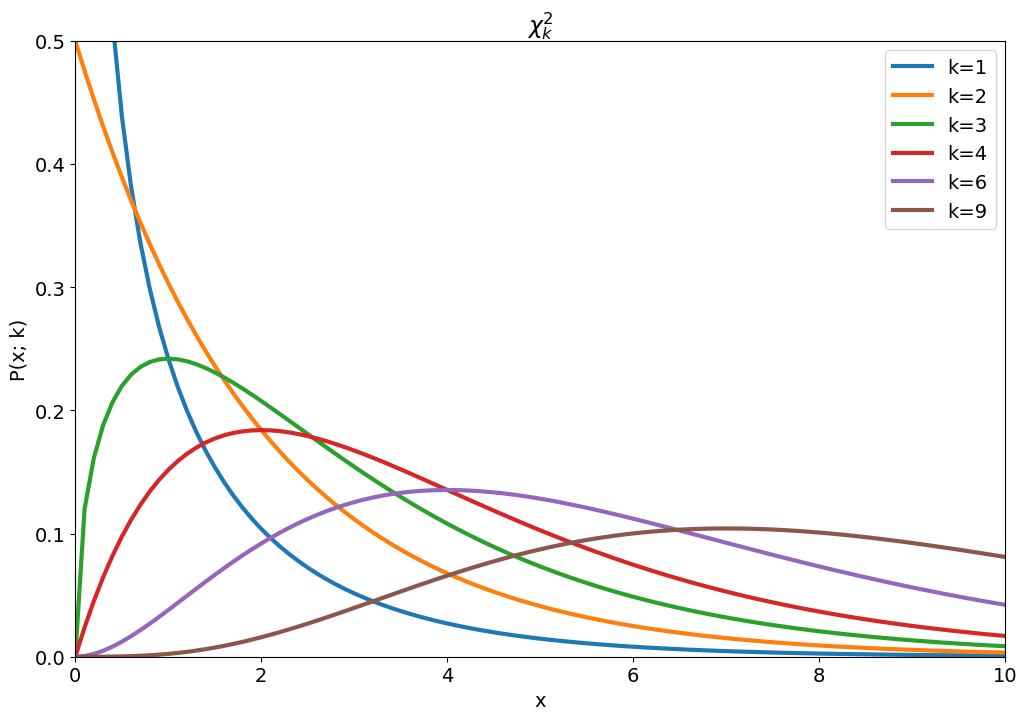

In [4]:
## Displaying the chi2 distribution for different numbers of freedom
x = np.linspace(0,10,101)
dof = [1,2,3,4,6,9]

fig, ax = plt.subplots(figsize=(12,8))
for dof_ in dof:
    chi2 = scipy.stats.chi2.pdf(x, dof_)
    ax.plot(x, chi2, linewidth=3, label='k={}'.format(dof_))

ax.legend()
ax.set_title('$\chi^2_k$')
ax.set_xlabel('x')
ax.set_ylabel('P(x; k)')
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.5);

<div class="opt_start">
    ⬇︎ Non-examinable content ⬇︎
</div>

### 5.2.4 Non-linear least squares

In the case of a model $f(x; \theta)$ which is a non-linear function of $\theta$ (e.g. $e^{\theta x}$, $\sin{(\theta x)}$) there is in general no analytic solution to solve the $M$ equations for each of the parameters in $\theta$. The MLE must be computed numerically.

Techniques to do so are beyond the scope of this course, but can involve gradient methods, simplex search, Monte Carlo, etc.

### 5.2.5 Best linear unbiased estimator

_[Note that this subsection is presented as optional, supplementary material only and will not be part of the examinable material. The notes follow from some of Cowan Chapter 7.6.]_

The principles behind combining data have already been discussed previously. How about combining measurements with least square?

Consider $N$ independent measurements $\{y_i\}$ with Gaussian errors $\{\sigma_i\}$ of a quantity $\theta$. In order to get the best average of all measurements we can minimize the $\chi^2$:
\begin{equation}
  \chi^2 = \sum_i^N \left( \frac{y_i - \theta}{\sigma_i} \right)^2 \,.
\end{equation}

Taking the derivative:
\begin{equation}
  \frac{\partial \chi^2}{\partial \theta} = -2 \sum_i^N \frac{y_i - \theta}{\sigma_i^2} \,.
\end{equation}

Setting it to zero, we find the MLE:
\begin{equation}
  \widehat{\theta} = \frac{\sum_i^N \frac{y_i}{\sigma_i^2}}{\sum_i^n \frac{1}{\sigma_i^2}} \,.
\end{equation}

And the variance after taking the second derivative:
\begin{equation}
  \sigma^2_{\widehat{\theta}} = \frac{1}{\sum_i^N \frac{1}{\sigma_i^2}} \,.
\end{equation}

We note that the smaller the error on a measurement, the larger its importance on the average value.

#### Correlated measurements

Let us suppose that we have correlated measurements instead, with the correlation between data points $i$ and $j$ described by the covariance matrix $V_{ij}$. The $\chi^2$ would be given by:

\begin{equation}
  \chi^2 = \sum_{i}^N \sum_{j}^N (y_i - \theta) V^{-1}_{ij} (y_j - \theta) \,.
\end{equation}

Similarly as before, the MLE is a linear function of the measurements:
Setting it to zero, we find the MLE:

\begin{equation}
  \widehat{\theta} = \sum_i^N w_i y_i \,,
\end{equation}

and its variance:

\begin{equation}
  \sigma^2_{\widehat{\theta}} = \sum_i^N \sum_j^N w_i V_{ij} w_j \,.
\end{equation}

The weights are given by:

\begin{equation}
  w_i = \frac{\sum_{j}^N V^{-1}_{ij}}{\sum_k^N \sum_l^N V^{-1}_{kl}} \,,
\end{equation}

with the condition that the sum of all weights must be equal to unity: $\sum_i^N w_i = 1$.

Let us consider the case of two correlated measurements with the following covariance matrix:

\begin{equation}
  V_{ij} = 
  \begin{pmatrix}
    \sigma_1^2 & \rho \sigma_1 \sigma_2 \\
    \rho \sigma_1 \sigma_2 & \sigma_2
  \end{pmatrix} \,.
\end{equation}

The inverse of the covariance matrix has an easy solution:

\begin{equation}
  V_{ij}^{-1} = \frac{1}{1-\rho^2}
  \begin{pmatrix}
    \frac{1}{\sigma_1^2} & \frac{-\rho}{\sigma_1 \sigma_2} \\
    \frac{-\rho}{\sigma_1 \sigma_2} & \frac{1}{\sigma_2}
  \end{pmatrix} \,.
\end{equation}

From this we can calculate the weights:

\begin{equation}
  w_1 = \frac{\frac{1}{\sigma_1^2} - \frac{\rho}{\sigma_1 \sigma_2}}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2} - 2 \frac{\rho}{\sigma_1 \sigma_2}} \,,
\end{equation}
and
\begin{equation}
  w_2 = 1 - w_1 \,.
\end{equation}

The variance is given by:

\begin{equation}
  \sigma^2_{\widehat{\theta}} = \frac{(1-\rho^2) \sigma_1^2 \sigma_2^2}{\sigma_1^2 + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2} \,.
\end{equation}

This correlation can lead to some rather unexpected result in the case $\rho > \frac{\sigma_1}{\sigma_2}$. In which case the weight becomes negative and the weighted average does not lie between the two individual values!

This method of combining data is known as the **best linear unbiased estimator** (BLUE).

### 5.2.6 Other topics

We will not see them in this course, but other topics of interest are:

- Least squares with boundary conditions (using Lagrange multipliers)
- Least squares of binned data

<div class="opt_end">
    ⬆︎ Non-examinable content ⬆︎
</div>

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>